# Amazon QA Dataset Analysis-

1. Defining the problem:
Aim to create a conversation datasets based on Amazon QA dataset

2. Source Dataset:
http://jmcauley.ucsd.edu/data/amazon/qa/

This dataset contains Question and Answer data from Amazon, totalling around 1.4 million answered questions.

The site contains 2 types of dataset - one where duplicate item reviews are removed, another set of dataset includes multiple answers to each question. 
We will first explore the prior one for simplying our problem statement.

There are also multiple product categories available in the dataset.
Lets first select only one category from the list (Beauty product category). This dataset consist of 42,422 questions.

In [ ]:
pip install missingno

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd

import gzip

# Start Python Imports
import math, time, random, datetime

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import json
from pandas.io.json import json_normalize


In [2]:
#Loading the Beauty product categories data
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

beauty_df = getDF('data/qa_Beauty.json.gz')

In [3]:
# View the beauty product qa data
beauty_df.head(10)

,questionType,asin,answerTime,question,answerType,answer,unixTime
0,yes/no,602260074X,10 days ago,can you fit make up brushes in the trays,Y,"yes it comes with adjustable dividers, you can...",NaN
1,yes/no,602260074X,"Mar 3, 2015",Can you move all the dividers?,?,"yes,all the provided dividers are adjustable",1.425370e+09
2,yes/no,602260074X,"Dec 30, 2014",is the surface in side the smooth?,Y,Yes,1.419926e+09
3,open-ended,602260074X,"Jul 13, 2014",How deep do the extending trays measure?,NaN,"Hi there, Not too deep. Maybe like an inch dee...",1.405235e+09
4,yes/no,602260074X,"May 21, 2014",Can bottles of nail polish stand upright in th...,?,No. We just tried it and it won't.,1.400656e+09
5,open-ended,602260074X,"Feb 25, 2014",what are the Weight?,NaN,Light box. Carry it anywhere.,1.393315e+09
6,open-ended,602260074X,"Dec 3, 2013",What are the dimensions?,NaN,I'm not sure but it ia good quality.,1.386058e+09
7,open-ended,602260074X,"Jul 23, 2013",What are the tray size dimensions please? Heig...,NaN,There are 4 trays when the box is open wide. T...,1.374563e+09
8,open-ended,7800558258,18 days ago,how can I get a product manual copy or electro...,NaN,good,NaN
9,open-ended,7800558258,"Feb 28, 2015",I have used the PE-901P. How does the D-901P c...,NaN,Thanks for your question. They are same item. ...,1.425110e+09


# Data Description

1. asin - ID of the product, e.g. B000050B6Z
2. questionType - type of question. Could be 'yes/no' or 'open-ended'
3. answerType - type of answer. Could be 'Y', 'N', or '?' (if the polarity of the answer could not be predicted). Only present for yes/no questions.
4. answerTime - raw answer timestamp
5. unixTime - answer timestamp converted to unix time
6. question - question text
7. answer - answer text

In [4]:
beauty_df.shape

(42422, 7)

In [5]:
beauty_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42422 entries, 0 to 42421
Data columns (total 7 columns):
questionType    42422 non-null object
asin            42422 non-null object
answerTime      42422 non-null object
question        42422 non-null object
answerType      18091 non-null object
answer          42422 non-null object
unixTime        40790 non-null float64
dtypes: float64(1), object(6)
memory usage: 2.6+ MB


## What missing value is there?

These are the rows which are missing a value or have NaN.

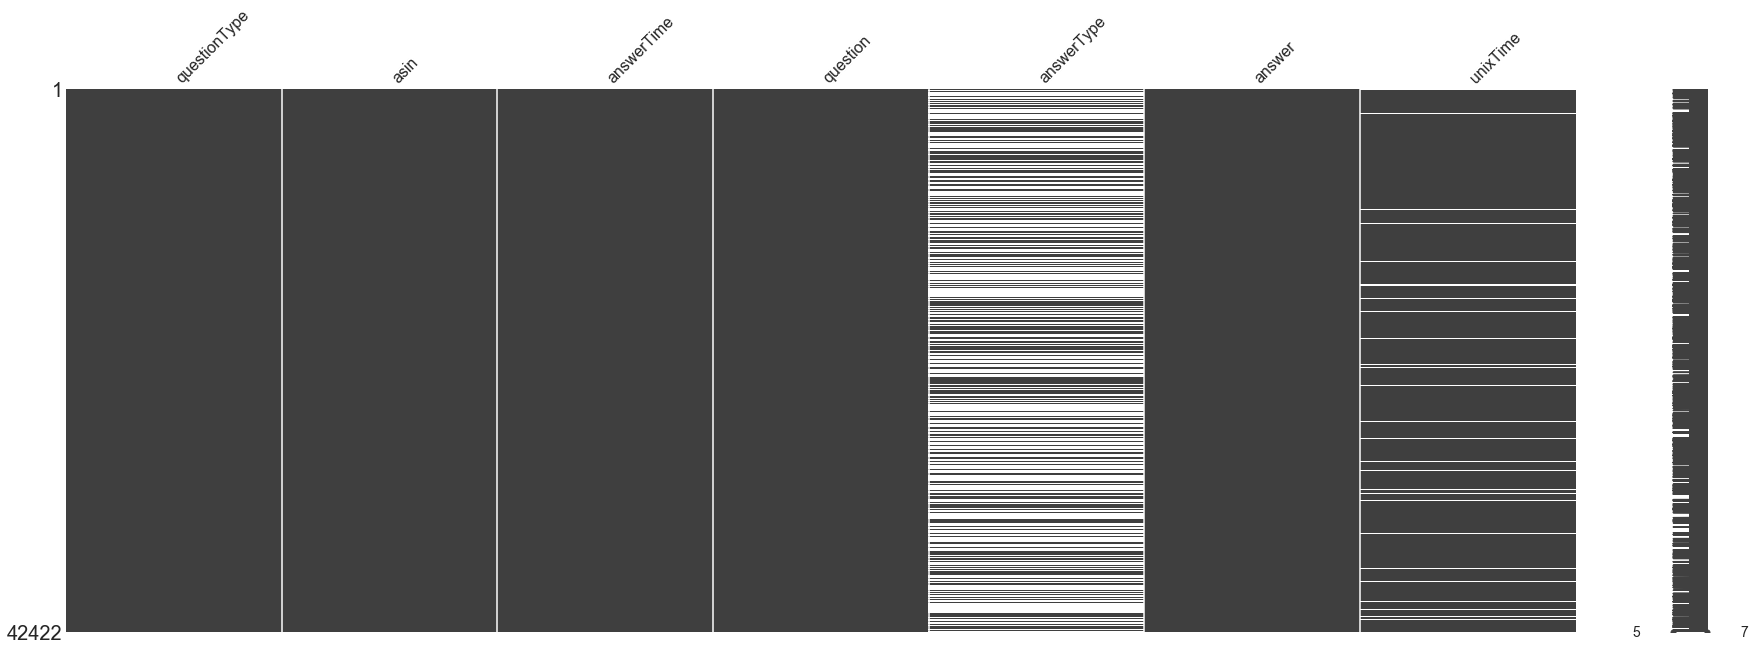

In [6]:
# Plot graphic of missing values
missingno.matrix(beauty_df, figsize= (30,10))

We can clearly see some missing values here. Especially in answerType column

Lets see the number of missing values

In [7]:
# Number of missing values in beauty qa category
beauty_df.isnull().sum()

questionType        0
asin                0
answerTime          0
question            0
answerType      24331
answer              0
unixTime         1632
dtype: int64

In [8]:
total = beauty_df.isnull().sum().sort_values(ascending=False)
percent_1 = beauty_df.isnull().sum()/beauty_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
answerType,24331,57.4
unixTime,1632,3.8
answer,0,0.0
question,0,0.0
answerTime,0,0.0


As we can see 57.4% of answerType is Null and 3.8% of unixTime is Null. Unix Time is derived from answerTime and it can  be dropped from dataset. And as part of answerType null values which is 57% of total answerType can also be dropped from dataset, will see in future if it impacts our analysis then will find some way to fill the missing values.

## What datatypes are in the dataframe? 

In [9]:
beauty_df.dtypes

questionType     object
asin             object
answerTime       object
question         object
answerType       object
answer           object
unixTime        float64
dtype: object

Need to understand these feature and a way to represent these features numerically so that machine learning model can learn from it.

## Let's create a new dataframe for exploring the dataset variables and explore each of these features individually

In [10]:
train_df = pd.DataFrame()

In [11]:
beauty_df.head(10)

,questionType,asin,answerTime,question,answerType,answer,unixTime
0,yes/no,602260074X,10 days ago,can you fit make up brushes in the trays,Y,"yes it comes with adjustable dividers, you can...",NaN
1,yes/no,602260074X,"Mar 3, 2015",Can you move all the dividers?,?,"yes,all the provided dividers are adjustable",1.425370e+09
2,yes/no,602260074X,"Dec 30, 2014",is the surface in side the smooth?,Y,Yes,1.419926e+09
3,open-ended,602260074X,"Jul 13, 2014",How deep do the extending trays measure?,NaN,"Hi there, Not too deep. Maybe like an inch dee...",1.405235e+09
4,yes/no,602260074X,"May 21, 2014",Can bottles of nail polish stand upright in th...,?,No. We just tried it and it won't.,1.400656e+09
5,open-ended,602260074X,"Feb 25, 2014",what are the Weight?,NaN,Light box. Carry it anywhere.,1.393315e+09
6,open-ended,602260074X,"Dec 3, 2013",What are the dimensions?,NaN,I'm not sure but it ia good quality.,1.386058e+09
7,open-ended,602260074X,"Jul 23, 2013",What are the tray size dimensions please? Heig...,NaN,There are 4 trays when the box is open wide. T...,1.374563e+09
8,open-ended,7800558258,18 days ago,how can I get a product manual copy or electro...,NaN,good,NaN
9,open-ended,7800558258,"Feb 28, 2015",I have used the PE-901P. How does the D-901P c...,NaN,Thanks for your question. They are same item. ...,1.425110e+09


### Feature : questionType

Description : type of question. Could be 'yes/no' or 'open-ended'

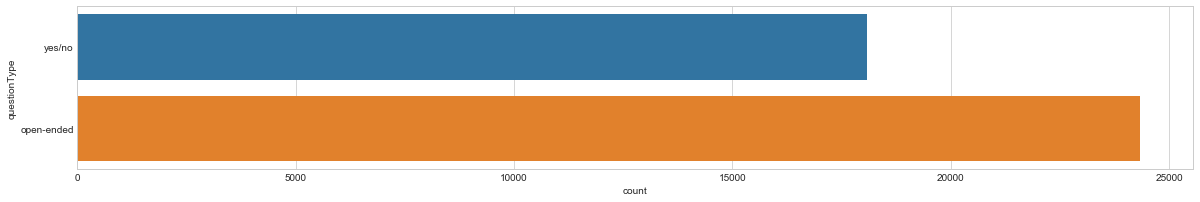

In [12]:
#Lets view the distribution of questionType
plt.figure(figsize=(20,3))
sns.countplot(y='questionType', data=beauty_df)

In [13]:
# Are there any missing values in the questionType column?
beauty_df.questionType.isnull().sum()

0

In [14]:
beauty_df.questionType.head()

0        yes/no
1        yes/no
2        yes/no
3    open-ended
4        yes/no
Name: questionType, dtype: object

Since its already a binary variable(yes/no or open-ended). Lets add it to our subset dataframe train_df

In [15]:
# add questionType to train_df dataframe
train_df['questionType'] = beauty_df['questionType']
train_df['questionType'] = np.where(train_df['questionType'] == 'yes/no', 1, 0) # change questionType of yes/no to 1 and open-ended to 0

In [16]:
train_df.head()

,questionType
0,1
1,1
2,1
3,0
4,1


### Feature : asin

Description - ID of the product, e.g. B000050B6Z

In [17]:
# How many different products are there?
beauty_df.asin.value_counts()

B0016B3QJY    10
B004SIZOQU    10
B002IACDGY    10
B00I55A4TY    10
B00DQG0PJQ    10
B006O473S8    10
B0023UOAME    10
B0043OYFKU    10
B008LQX8J0    10
B00021DVEY    10
B003V21WO2    10
B00ICVMZFC    10
B0049OLZ84    10
B005TTSDYW    10
B006NAIUBM    10
B003GDK6F2    10
B00GMPYI8M    10
B001N444JU    10
B003CIM9HO    10
B00IMKSZTS    10
B004673A8C    10
B004220E80    10
B00317FT4G    10
B002NGMEV2    10
B00AOUCN1K    10
B005SRTDWQ    10
B000MK2J16    10
B003B8G5IY    10
B000QT9OP2    10
B00013YZ7U    10
              ..
B001KYQ4NW     3
B00AGSAQBE     3
B001FWXISS     3
B00CF6M0NC     3
B00026CZCS     3
B0069W1OEE     3
B0015XNAQ2     3
B00BFD1JRY     2
B000052YMO     2
B001AKHMIC     2
B001AKNQPK     2
B003VKJCN2     2
B000C213V6     2
B001ARV2MC     2
B0085XUB8A     2
B0050BJ6NG     2
B00C7VZ8DY     2
B00JJ58GTO     2
B001N84YRS     2
B001AKWZCU     2
B001RYQN5O     2
B00EO6KSC6     2
B00BGWARJK     2
B001AKOH44     1
B001AKV1HU     1
B001AKV1IY     1
B001AKQC0Q     1
B000FELJ7Y    

asin is a categorical data as it represents specific finite set of beauty product categories. There are various ways to encode categorical data. Most used ones are label encoder, one hot encoder. Label encoder is basically assigning labels to each category , which is not possible in our case as we have 5906 category to be labelled. And what one hot encoding does is, it takes a column which has categorical data, which has been label encoded, and then splits the column into multiple columns. The numbers are replaced by 1s and 0s, depending on which column has what value. This is also not possible in our case as we can't have that 5906 features in our dataset. It might cause ‘curse of dimensionality’ where basically with an enormous number of features and not enough representative samples, model performance starts getting affected often leading to overfitting.

To avoid all of these issues, we will try to encode our product category using Feature Hashing Scheme. In this scheme, a hash function is typically used with the number of encoded features pre-set (as a vector of pre-defined length) such that the hashed values of the features are used as indices in this pre-defined vector and values are updated accordingly.



In [19]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=10, input_type='string')
hashed_features = fh.fit_transform(beauty_df['asin'])
hashed_features = hashed_features.toarray()
train_df = pd.concat([train_df[['questionType']],beauty_df['asin'], pd.DataFrame(hashed_features)], 
          axis=1)

In [20]:
train_df.head(10)

,questionType,asin,0,1,2,3,4,5,6,7,8,9
0,1,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
1,1,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
2,1,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
3,0,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
4,1,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
5,0,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
6,0,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
7,0,602260074X,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.0
8,0,7800558258,3.0,1.0,0.0,-3.0,0.0,0.0,0.0,0.0,1.0,-2.0
9,0,7800558258,3.0,1.0,0.0,-3.0,0.0,0.0,0.0,0.0,1.0,-2.0


In [21]:
beauty_df

,questionType,asin,answerTime,question,answerType,answer,unixTime
0,yes/no,602260074X,10 days ago,can you fit make up brushes in the trays,Y,"yes it comes with adjustable dividers, you can...",NaN
1,yes/no,602260074X,"Mar 3, 2015",Can you move all the dividers?,?,"yes,all the provided dividers are adjustable",1.425370e+09
2,yes/no,602260074X,"Dec 30, 2014",is the surface in side the smooth?,Y,Yes,1.419926e+09
3,open-ended,602260074X,"Jul 13, 2014",How deep do the extending trays measure?,NaN,"Hi there, Not too deep. Maybe like an inch dee...",1.405235e+09
4,yes/no,602260074X,"May 21, 2014",Can bottles of nail polish stand upright in th...,?,No. We just tried it and it won't.,1.400656e+09
5,open-ended,602260074X,"Feb 25, 2014",what are the Weight?,NaN,Light box. Carry it anywhere.,1.393315e+09
6,open-ended,602260074X,"Dec 3, 2013",What are the dimensions?,NaN,I'm not sure but it ia good quality.,1.386058e+09
7,open-ended,602260074X,"Jul 23, 2013",What are the tray size dimensions please? Heig...,NaN,There are 4 trays when the box is open wide. T...,1.374563e+09
8,open-ended,7800558258,18 days ago,how can I get a product manual copy or electro...,NaN,good,NaN
9,open-ended,7800558258,"Feb 28, 2015",I have used the PE-901P. How does the D-901P c...,NaN,Thanks for your question. They are same item. ...,1.425110e+09


### Feature : question

Description - question text which is asked for that particular product